In [1]:
# 10-11-2023, Oren - Classification Project Notebook

In [2]:
from pandas import read_csv
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, \
    AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings("ignore")
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve

def csv_drive_path_generatoer(url):
 '''
 Help in read csv file directly from google drive.
 Make sure the csv format is standard.
 url:str - path to csv file example:
   url = 'https://drive.google.com/file/d/126JPZ3lYwdLyJ2d_7jxM9jMtZaOlF-Ld/view?usp=sharing'
 return : str
 '''
 path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
 return path

In [3]:
link_X_train = 'https://drive.google.com/file/d/11Dgctv-N6z3ugQOpRrFNKVP5NNqPPWxK/view?usp=drive_link'
link_y_train = 'https://drive.google.com/file/d/1NDF2aCymR4zjYK9mLYNRwIdB_EyE5ZHl/view?usp=drive_link'

link_X_test = 'https://drive.google.com/file/d/1ZRg80tYdBO1pcd_6R1m_tiijZSfDXMZ6/view?usp=drive_link'

path_X_train = csv_drive_path_generatoer(link_X_train)
path_y_train = csv_drive_path_generatoer(link_y_train)

path_X_test = csv_drive_path_generatoer(link_X_test)

X_train = read_csv(path_X_train, index_col = 0)
y_train = read_csv(path_y_train, index_col = 0)

X_test = read_csv(path_X_test, index_col = 0)

train_data = X_train.join(y_train).set_index('id')

In [4]:
train_data

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,Race,LeaveOrNot
id,,,,,,,,,,
1847,Bachelors,2016,Bangalore,3,27.0,Male,Yes,4,white,0
2905,Bachelors,2012,Bangalore,3,28.0,Male,No,4,white,0
4610,Bachelors,2015,Pune,3,26.0,Female,No,2,white,1
2228,Bachelors,2012,Bangalore,3,29.0,Male,No,1,black,0
5,Bachelors,2016,Bangalore,3,24.0,Male,No,0,white,0
...,...,...,...,...,...,...,...,...,...,...
3335,Bachelors,2016,Bangalore,3,38.0,Female,No,0,white,0
1099,Masters,2017,Pune,2,29.0,Male,No,5,white,1
2514,Bachelors,2016,Pune,3,31.0,Male,No,5,black,0


In [5]:
# Defining a data-Transformation class to elegantly perform all data transformation steps by class methods upon class object instansiation 
# can be accessed via the .data class attribute

# 0. Remove nulls
# 1. add tenure feature - current - specified year
# 2. Transform Education values to 1, 2, 3
# 3. Transform EverBenched values to 1 or 0
# 4. Gender, City & Race - One-Hot encoding
# 5. remove extra columns

class DataTransformer:
    
    def __init__(self, data):
        self.data = data
        self.remove_nulls()
        self.add_tenure()
        self.numeric_education()
        self.numeric_everbenched()
        self.one_hot_encoder()
        self.remove_extra_columns()
            
    def remove_nulls(self, column = 'Age'):
        self.data = self.data[~self.data[column].isnull()]
    
    def add_tenure(self,current_year = 2023):
        self.data["Loan's_Tenure"] = current_year - self.data.JoiningYear

    def numeric_education(self):
        self.data['Education'] = self.data['Education'].replace({'Bachelors': 1,'Masters': 2,'PHD': 3})
        
    def numeric_everbenched(self):
        self.data['EverBenched'] = self.data['EverBenched'].replace({'Yes':1, 'No': 0})        

    def one_hot_encoder(self, columns = ['Gender', 'Race', 'City']):
        self.data = pd.get_dummies(self.data, columns = columns, prefix = columns, dtype = int)
            
    def remove_extra_columns(self):
        self.data = self.data.drop(columns = ['JoiningYear'])

In [6]:
# Create an instance of the DataTransformer and save the transformed df via the .data class attribute configured

trans_train_data = DataTransformer(train_data)

trans_train_data = trans_train_data.data

trans_train_data


,Education,PaymentTier,Age,EverBenched,ExperienceInCurrentDomain,LeaveOrNot,Loan's_Tenure,Gender_Female,Gender_Male,Race_black,Race_red,Race_white,Race_yellow,City_Bangalore,City_New Delhi,City_Pune
id,,,,,,,,,,,,,,,,
1847,1,3,27.0,1,4,0,7,0,1,0,0,1,0,1,0,0
2905,1,3,28.0,0,4,0,11,0,1,0,0,1,0,1,0,0
4610,1,3,26.0,0,2,1,8,1,0,0,0,1,0,0,0,1
2228,1,3,29.0,0,1,0,11,0,1,1,0,0,0,1,0,0
5,1,3,24.0,0,0,0,7,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,1,3,38.0,0,0,0,7,1,0,0,0,1,0,1,0,0
1099,2,2,29.0,0,5,1,6,0,1,0,0,1,0,0,0,1
2514,1,3,31.0,0,5,0,7,0,1,1,0,0,0,0,0,1


In [7]:
# Data Normalization/Scaling from 0 to 1 (per feature)
scaler = MinMaxScaler()
scaled_train_data = pd.DataFrame(scaler.fit_transform(trans_train_data), index=trans_train_data.index, columns=trans_train_data.columns)
# scaled_train_data

In [8]:
# seperating the original train data to X and y:
X = scaled_train_data.drop(columns = 'LeaveOrNot')
y = scaled_train_data.LeaveOrNot

# Train_test_split - splitting original train data to train and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
# Create single decision tree classifier 

clf_dt = DecisionTreeClassifier(max_depth = 6)
clf_dt.fit(X_train, y_train)

y_test_pred = clf_dt.predict(X_test)

In [10]:
# evaluate the results

# Confusion matrix
cm = confusion_matrix(y_true = y_test, y_pred = y_test_pred)
target_names = ['0', '1']
cm = pd.DataFrame(data = cm, index = target_names, columns = target_names)
print(cm)

# Classification report
cr = classification_report(y_test,y_test_pred, target_names = target_names)
print(cr)

     0    1
0  730   50
1  134  314
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       780
           1       0.86      0.70      0.77       448

    accuracy                           0.85      1228
   macro avg       0.85      0.82      0.83      1228
weighted avg       0.85      0.85      0.85      1228



In [46]:
def plot_roc_curve(X_train, X_test, y_train, y_test, ensemble_classifier):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]

    # clf = DecisionTreeClassifier()
    # model_a_bagging = BaggingClassifier(estimator = base_model, n_estimators= 100)

    # fitting the models
    ensemble_classifier.fit(X_train, y_train)

    # predict probabilities
    probas = ensemble_classifier.predict_proba(X_test)

    # keep probabilities for the positive outcome only
    probas = probas[:,1]

    # calculate rocs auc scores
    auc = roc_auc_score(y_test, probas)

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs, pos_label = 1)
    fpr, tpr, _ = roc_curve(y_test, probas, pos_label = 1)

    # plot the roc curve for the model

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label=f"'DecisionTreeClassifier_max_depth = 6', auc = {auc:.3f}")

    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # show the legend
    plt.legend()


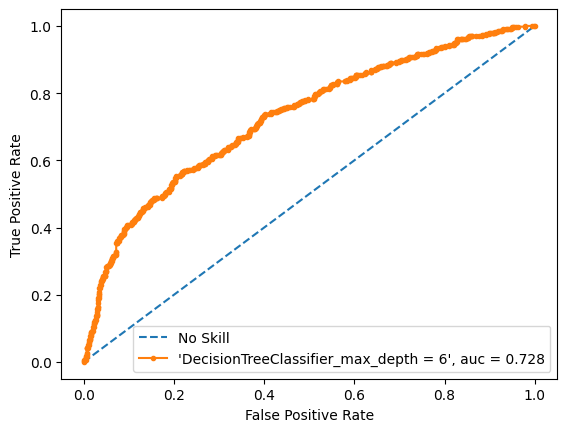

In [48]:
plot_roc_curve(X_train, X_test, y_train, y_test, BaggingClassifier(estimator = LogisticRegression(), n_estimators= 100))

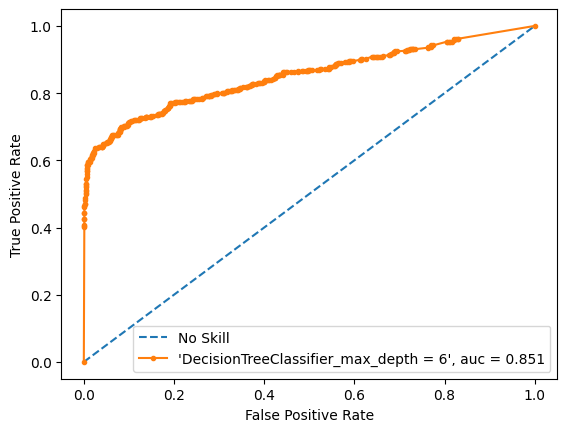

In [45]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# model_a
# model_a = LogisticRegression()
clf = DecisionTreeClassifier()
model_a_bagging = BaggingClassifier(estimator = clf, n_estimators= 100)

# fitting the models
model_a_bagging.fit(X_train, y_train)

# predict probabilities
a_probas = model_a_bagging.predict_proba(X_test)

# keep probabilities for the positive outcome only
a_probas = a_probas[:,1]

# calculate rocs auc scores
a_auc = roc_auc_score(y_test, a_probas)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs, pos_label = 1)
a_fpr, a_tpr, _ = roc_curve(y_test, a_probas, pos_label = 1)

# plot the roc curve for the model

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(a_fpr, a_tpr, marker='.', label=f"'DecisionTreeClassifier_max_depth = 6', auc = {a_auc:.3f}")

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

In [34]:
y_test.unique()

array([1., 0.])

0.8412750651873955